<a href="https://colab.research.google.com/github/szezlong/gene-classification/blob/main/Gene_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikacja choroby nowotworowej za pomocą analizy ekspresji genów
Źródło zbioru danych: https://www.kaggle.com/datasets/crawford/gene-expression/data?select=actual.csv

Pochodzi z badania: https://www.dkfz.de/genomics-proteomics/fileadmin/downloads/Expression/Golub_1999.pdf

The dataset used in Golub's research was sourced from bone marrow samples obtained from patients diagnosed with acute leukemia. It included samples of acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML).

It served as the basis for developing a class predictor to classify new, unknown samples of acute leukemias based on their gene expression profiles.

##Konfiguracja środowiska

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d crawford/gene-expression
!unzip "gene-expression.zip"

Dataset URL: https://www.kaggle.com/datasets/crawford/gene-expression
License(s): CC0-1.0
  0% 0.00/1.41M [00:00<?, ?B/s]
100% 1.41M/1.41M [00:00<00:00, 98.8MB/s]
Archive:  gene-expression.zip
  inflating: actual.csv              
  inflating: data_set_ALL_AML_independent.csv  
  inflating: data_set_ALL_AML_train.csv  


In [ ]:
train_df = pd.read_csv('data_set_ALL_AML_train.csv')
test_df = pd.read_csv('data_set_ALL_AML_independent.csv')
patient_result_df = pd.read_csv('actual.csv')

###Opis danych

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood.

In [ ]:
patient_result_df['cancer'].value_counts()

cancer
ALL    47
AML    25
Name: count, dtype: int64

In the combined training and testing sets there are 72 patients. Each patient is marked either as "ALL" or "AML" based on the type of leukemia they are diagnosed with.

In [ ]:
print(train_df.shape)
print(test_df.shape)

(7129, 78)
(7129, 70)


In [ ]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
test_df.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


The gene descriptions, numbering 7129 in total, are listed in the rows, while each patient's values are displayed in the columns.

##Preprocessing

In [ ]:
keep_train = [col for col in train_df.columns if "call" not in col]
keep_test = [col for col in test_df.columns if "call" not in col]

train_df = train_df[keep_train]
test_df = test_df[keep_test]

Podjęto decyzję o usunięciu kolumn 'call'. Kolumny te nie są nigdzie wyjaśnione. Co więcej, wartości dla różnych genów w jednej kolumnie 'call' są takie same, co sugeruje, że te kolumny mogą nie mieć znaczenia w analizie genów.

In [ ]:
train_df = train_df.T
test_df = test_df.T

In [ ]:
train_df.columns = train_df.iloc[1]
train_df = train_df.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
train_df.index = pd.to_numeric(train_df.index) #ta linijka chyba nie jest must-have
train_df.sort_index(inplace=True) #ta linijka chyba nie jest must-have
train_df.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [ ]:
test_df.columns = test_df.iloc[1]
test_df = test_df.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
test_df.index = pd.to_numeric(test_df.index) #ta linijka chyba nie jest must-have
test_df.sort_index(inplace=True) #ta linijka chyba nie jest must-have
test_df.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
41,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
43,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,341,91,-84,615,-52,1235,9,7,1545,-81


In [ ]:
print(train_df.shape)
print(test_df.shape)

(38, 7129)
(34, 7129)


Otrzymano 38 pacjentów jako wiersze w zbiorze treningowym, a pozostałych 34 jako wiersze w zbiorze testowym. Zbiory te zawierają informacje na temat ekspresji 7129 genów dla każdego pacjenta.

In [ ]:
train_df = train_df.reset_index(drop=True)
train_df = train_df.merge(patient_result_df[['cancer']], how='left', left_index=True, right_index=True)

In [ ]:
dic = {'ALL':0,'AML':1}
train_df.replace(dic,inplace=True)
train_df.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,0


In [ ]:
test_df = test_df.reset_index(drop=True)
test_df = test_df.merge(patient_result_df[['cancer']], how='left', left_index=True, right_index=True)
test_df.replace(dic,inplace=True)
test_df.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,1023,67,214,-135,1074,475,48,168,-70,0
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,529,-295,352,-67,67,263,-33,-33,-21,0
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,383,46,104,15,245,164,84,100,-18,0
3,22,-153,17,276,-211,-250,55,-141,0,500,...,399,16,558,24,893,297,6,1971,-42,0
4,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,91,-84,615,-52,1235,9,7,1545,-81,0


Do danych dodano informację o typie rozpoznanego nowotworu (ALL = 1, AML = 0)
//mam nadzieję że dobrze...

In [ ]:
tr_nulls = train_df.isnull().sum().sum()
tr_nans = train_df.isna().sum().sum()

print("Liczba wartości null:", tr_nulls)
print("Liczba wartości NaN:", tr_nans)

Liczba wartości null: 0
Liczba wartości NaN: 0


In [ ]:
ts_nulls = test_df.isnull().sum().sum()
ts_nans = test_df.isna().sum().sum()

print("Liczba wartości null:", ts_nulls)
print("Liczba wartości NaN:", ts_nans)

Liczba wartości null: 0
Liczba wartości NaN: 0


W zbiorze nie ma pustych wartości

##Selekcja istotnych genów
(100-300)

In [ ]:
train_df.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526,0.289474
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132,0.459606
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000,0.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000,0.000000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000,0.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000,1.000000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000,1.000000


###Normalizacja

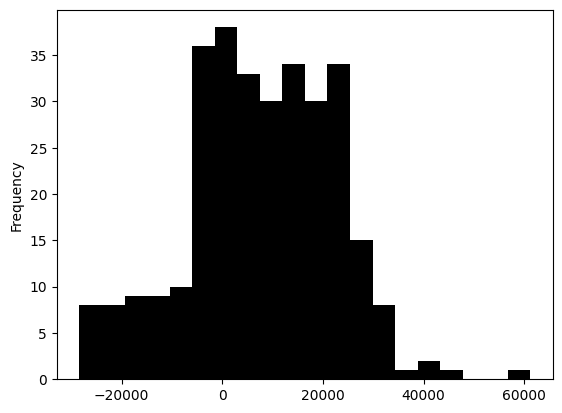

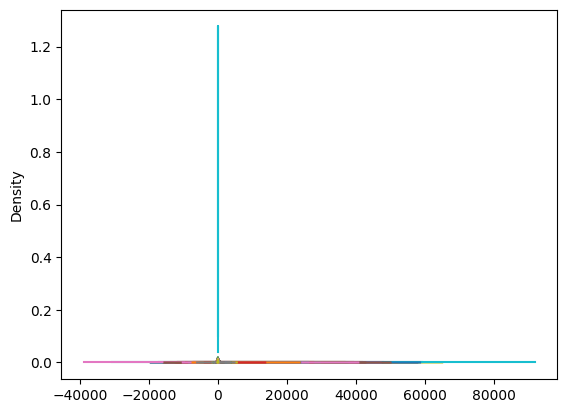

In [ ]:
from sklearn import preprocessing

train_df.iloc[:, :-1].plot(kind="hist", legend=None, bins=20, color='k')
train_df.plot(kind="kde", legend=None);

Na histogramie i wykresie gęstości widać różnice w zakresach wartości i obecność wartości odstających. Standaryzacja jest potrzebna, aby zniwelować te różnice w skali i rozkładzie danych.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_df.iloc[:,:-1])
train_scaled = pd.DataFrame(scaler.transform(train_df.iloc[:,:-1]))
test_scaled = pd.DataFrame(scaler.transform(test_df.iloc[:,:-1]))

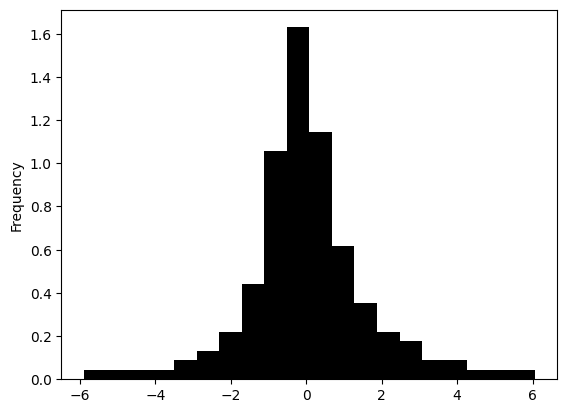

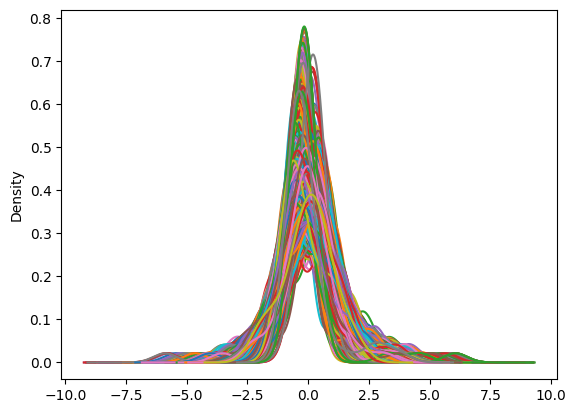

In [ ]:
train_scaled.plot(kind="hist", density=True, legend=None, bins=20, color='k')
train_scaled.plot(kind="kde", legend=None);

W wyniku standaryzacji danych wykresy stały się bardziej symetryczne, a cechy zostały sprowadzone do wspólnej skali.

In [ ]:
train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,0.074511,-0.815620,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.116640,0.292993,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,1.627617,1.524030,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,0.731595,0.286192,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,-0.271951,-0.346330,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311


###Principal Component Analysis

W projekcie z dużą liczbą cech (ponad 7000 genów) i stosunkowo małą liczbą próbek (38 pacjentów), PCA jest użyteczne, w celu redukcji wymiarowości danych. Ponadto, może pomóc w uniknięciu overfittingu modelu.

In [ ]:
from sklearn.decomposition import PCA

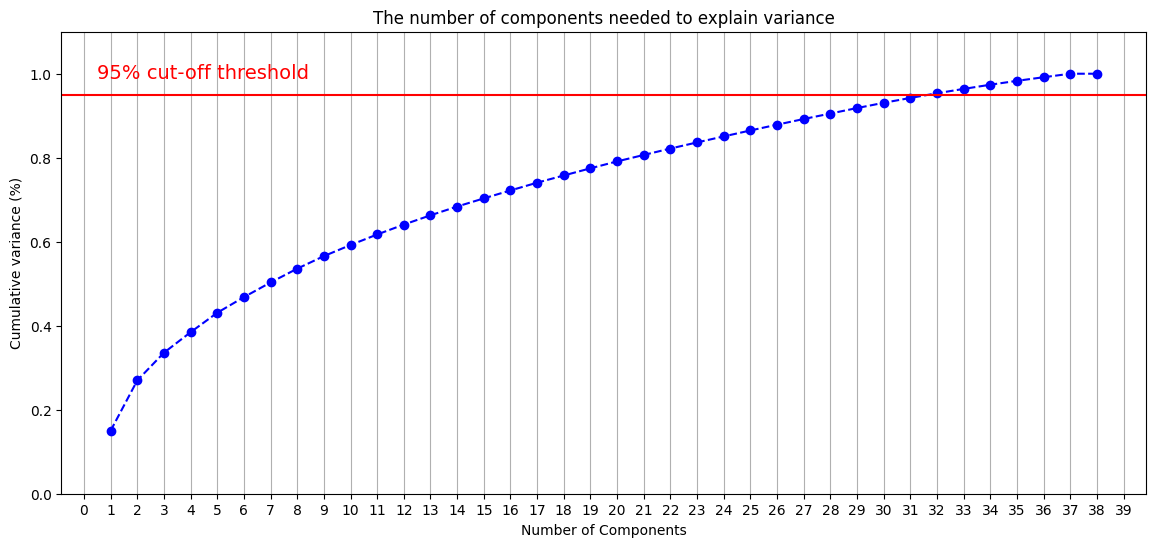

In [ ]:
pca = PCA().fit(train_scaled)

plt.rcParams["figure.figsize"] = (14,6)
fig, ax = plt.subplots()
xi = np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 40, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.99, '95% cut-off threshold', color = 'red', fontsize=14)

# plt.axhline(y=0.9, color='m', linestyle='-')
# plt.text(0.5, 0.85, '90% cut-off threshold', color = 'magenta', fontsize=14)

ax.grid(axis='x')

95% wariancji jest tłumaczona przez 32 składowe - zdecydowanie mniejsza liczba cech do analizy, niż poprzednie ponad 7 tysięcy.

In [ ]:
X_train = pd.DataFrame(PCA(n_components=32).fit_transform(train_scaled))
X_test = pd.DataFrame(PCA(n_components=32).fit_transform(test_scaled))

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,18.544799,5.826943,-19.442313,-11.267566,5.303304,19.100937,-9.447438,0.915309,-8.665217,-7.912754,...,5.630107,-4.538090,-14.672156,4.899964,9.335462,-12.552358,2.484640,12.217094,4.453306,3.547129
1,-7.341389,10.008663,11.795698,3.920823,-13.999094,-18.636026,4.687060,8.812418,1.372678,-11.690751,...,-10.669290,-5.364779,-20.280586,7.685347,23.676243,5.216321,17.828269,-1.015588,-16.729140,-0.297116
2,52.852146,11.390630,-29.548566,-38.800348,-22.866689,-9.458113,-22.880735,20.995112,4.038731,-5.260765,...,5.073579,0.797486,0.995521,-0.354742,-0.093794,2.769450,-2.868344,7.354274,-2.709089,4.263477
3,13.688551,-6.246839,-22.623318,-3.982670,-1.351354,13.095198,29.457761,-10.493627,-12.248064,22.248153,...,1.204654,8.036715,21.272887,20.388530,9.384894,1.410416,24.731438,-8.574276,5.005685,8.610738
4,-36.790106,32.799698,5.253314,-2.790336,-6.602306,10.731372,2.410778,-4.505205,-9.751938,1.651788,...,5.829900,-0.235727,3.875653,-2.760198,-2.021964,-2.234259,-2.444749,14.045705,-1.903950,-13.114708


In [ ]:
print(X_train.shape)
print(X_test.shape)

(38, 32)
(34, 32)


Ostatecznie udało nam się wyekstrahować 32 główne składowe, spośród 7 tys. cech. Dzięki temu wyeliminowano szum i redundancję, zachowując jak najwięcej istotnych informacji z danych.

> dużo mniej niż 100-300, mam nadzieje że będzie służyć wysokiej accuracy itp.



####Analiza wag głównych składowych

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=train_scaled.columns)

In [ ]:
# Wyświetlenie top 10 najważniejszych genów dla każdej głównej składowej
top_genes = {}
for i in range(1, pca.n_components_ + 1):
    top_genes[f'PC{i}'] = loadings_df[f'PC{i}'].abs().sort_values(ascending=False).head(10)

# Sumowanie wag dla każdej cechy, aby uzyskać ich całościowy wpływ
loadings_sum = loadings_df.abs().sum(axis=1)
top_overall_genes = loadings_sum.sort_values(ascending=False).head(10)

# Wyświetlenie wyników
print("Top 10 najważniejszych genów dla każdej głównej składowej:")
for key, value in top_genes.items():
    print(f"\n{key}:")
    print(value)

print("\nTop 10 genów o największym wpływie ogólnym:")
print(top_overall_genes)

Top 10 najważniejszych genów dla każdej głównej składowej:

PC1:
3835    0.961345
6337    0.960105
6136    0.954837
3838    0.952619
4833    0.948123
4636    0.944338
4131    0.936064
4691    0.929640
5047    0.924151
6454    0.922252
Name: PC1, dtype: float64

PC2:
3560    0.943294
3783    0.941294
3506    0.937565
2347    0.927429
3610    0.925095
1896    0.924915
5568    0.923462
1583    0.921890
589     0.917933
3136    0.916238
Name: PC2, dtype: float64

PC3:
1393    0.853520
1248    0.842031
2241    0.838502
2042    0.836481
1673    0.834689
4846    0.834413
921     0.830745
6875    0.828267
3257    0.822513
1094    0.821106
Name: PC3, dtype: float64

PC4:
2858    0.794941
6532    0.742449
1724    0.721629
5385    0.699562
5935    0.696796
6882    0.693637
211     0.686252
338     0.686211
6201    0.677544
5990    0.669664
Name: PC4, dtype: float64

PC5:
2155    0.779500
3256    0.734363
2379    0.728532
119     0.704850
5638    0.697873
3641    0.691801
2238    0.684987
810     

zrobiłam to, żeby zrobić selekcje 100-300 genów ale nie wiem, czy juz to PCA nie wystarczy wsm, można na koniec jeszcze porównać ewentualnie

##Budowa klasyfikatora

Nie ma potrzeby dzielenia danych na 80% - zbiór uczący i 20% - zbiór testowy, ponieważ dane są już w postaci jednego zbioru treningowego (train_df, 38 wierszy) i jednego zbioru testowego (test_df, 34 wiersze)

In [ ]:
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [41]:
#BASELINE
print("Simply predicting everything as ALL in Train set:  ",
      round(1 - np.mean(y_train), 3), ".", sep = '')
print("Simply predicting everything as ALL in Test set:  ",
      round(1 - np.mean(y_test), 3), ".", sep = '')

Simply predicting everything as ALL in Train set:  0.711.
Simply predicting everything as ALL in Test set:  0.794.


//zasadniczo korzystanie z PCA jest uzasadnione, bo mamy zdecydowanie zmniejszony wymiar, a i tak nie zalezalo nam na interpretowalnosci wyników

###**XGBoost**

###**Random Forest**

In [29]:
params = {
    'bootstrap': [False, True],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'n_estimators': [50, 100, 150, 200, 300],
    'min_samples_leaf': [1, 2, 8, 12],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 2, 10, 20],
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=5,
    verbose=1,
)

grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 6720 candidates, totalling 33600 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [38]:
rf_model_best = grid_search_rf.best_estimator_

test_pred = rf_model_best.predict(X_train)
print('Random Forest Train accuracy:', round(accuracy_score(y_train, rf_pred), 3))

rf_pred = rf_model_best.predict(X_test)
print('Random Forest Test accuracy:', round(accuracy_score(y_test, rf_pred), 3))

Random Forest Train accuracy: 1.0
Random Forest Test accuracy: 0.735


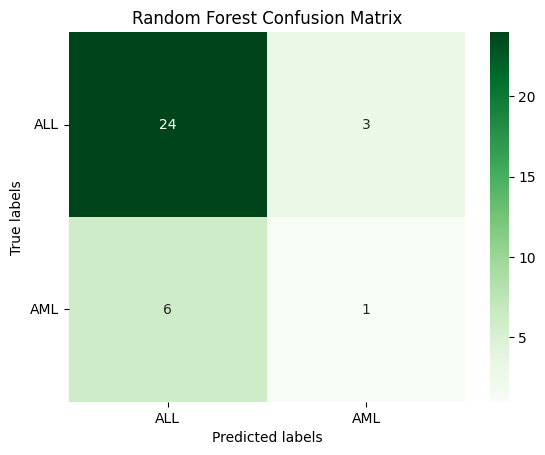

In [33]:
import seaborn as sns

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens')

labels = ['ALL', 'AML']

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

Słaby wynik, gorzej przewiduje niż gdyby z góry wszystkich pacjentów zaliczył do grupy ALL - prawdopodobnie mogło dojść do overfittingu

###**Neural Network**